# Objective

The objective of this notebook is to explore the effects of different binding kinetics of bispecific T cell engagers in the tumor microenvironment.

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings

default(; # Plots defaults
    fontfamily="Computer modern"
    )

In [15]:
import Pkg; Pkg.add("LaTeXStrings")

    Updating registry at `~/.julia/registries/JuliaComputingRegistry`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed libvorbis_jll ─ v1.3.7+1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [b964fa9f] + LaTeXStrings v1.3.0
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [f27f6e37] ↑ libvorbis_jll v1.3.7+0 ⇒ v1.3.7+1
Precompiling project...
  ✓ libvorbis_jll
  ✓ FFMPEG_jll
  ✓ FFMPEG
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  6 dependencies successfully precompiled in 38 seconds (330 already precompiled)
  6 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


# Trimer formation in tumor micro environment

Drug concentration in the tme is $C_t$, CD3 target is $T1_t$ and Pcad is $T2_t$. No internalization.

$
\begin{align}
\dot{C} &  = - k_{n1} T1 C - k_{n2} T2 C + k_{f1} D1 + k_{f2} D2,\\
        \dot{T1} & = - k_{n1} T1 C + k_{f1} D1 - k_{n1} T1 D2 + k_{f1} Trimer,\\
        \dot{T2} & = - k_{n2} T2 C + k_{f2} D2 - k_{n2} T2 D1 + k_{f2} Trimer,\\
        \dot{D1} & = k_{n1} T1 C - k_{f1} D1 - k_{n2} T2 D1 + k_{f2} Trimer ,\\
        \dot{D2} & = k_{n2} T2 C + k_{f2} D2 - k_{n1} T1 D2 + k_{f1} Trimer,\\
        \dot{Trimer} & = k_{n1} T1 D2 + k_{n2} T2 D1 - (k_{f1}+k_{f2}) Trimer.
\end{align}
$

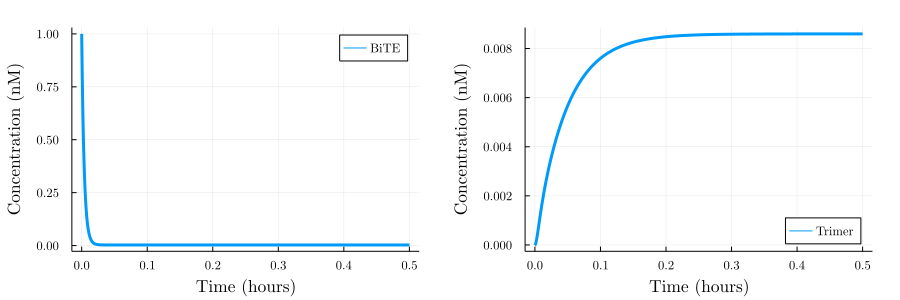

In [2]:
function TME(du,u,p,t)
    Cₜ, T1ₜ, T2ₜ, D1ₜ, D2ₜ, Rₜ = u
    kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kn₁*T1ₜ*Cₜ -kn₂*T2ₜ*Cₜ +kf₁*D1ₜ +kf₂*D2ₜ
    du[2]= -kn₁*T1ₜ*Cₜ +kf₁*D1ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Rₜ
    du[3]= -kn₂*T2ₜ*Cₜ +kf₂*D2ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Rₜ
    du[4]= +kn₁*T1ₜ*Cₜ -kf₁*D1ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Rₜ
    du[5]= +kn₂*T2ₜ*Cₜ -kf₂*D2ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Rₜ
    du[6]= +kn₁*T1ₜ*D2ₜ +kn₂*T2ₜ*D1ₜ -(kf₁+kf₂)*Rₜ
end

x0 = [1e0,1.08e-1,166,0.0,0.0,0.0]
ts = (0.0,0.5)
p  = [1.72,19.66,1.57,0.74]
TMEproblem  = ODEProblem(TME,x0,ts,p)
TMEsolution = solve(TMEproblem, abstol=1e-18, reltol=1e-18)

p1 = plot(TMEsolution.t,TMEsolution[1,:],linewidth=3,label="BiTE",
         ylabel="Concentration (nM)", xlabel="Time (hours)")
p2 = plot(TMEsolution.t,TMEsolution[6,:],linewidth=3,label="Trimer",
         ylabel="Concentration (nM)", xlabel="Time (hours)", legend=:bottomright)
p  = plot(p1,p2, layout=(1,2), size=(900,300), margin=5mm)
savefig(p, "TME_1.png")
savefig(p, "TME_1.pdf")
p

# Dish experiments

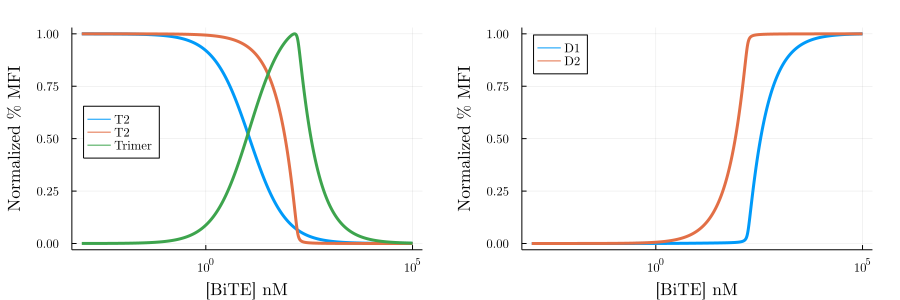

In [3]:
function simulate(problem, dose)
    ss = zeros(length(dose),6)
    problem = remake(problem; tspan=(0.0,1e3))
    for index=1:length(dose) 
        problem_ = remake(problem, u0=vcat(dose[index], problem.u0[2:end]))
        solution = solve(problem_)
        ss[index,:] = solution[:,end]'
    end
    return ss
end

function mfi(problem,l,b, name)
    dose = 10 .^(range(l,b,length=1000)) # change l and b customize x axis
    m = simulate(problem, dose)
    p1 = plot(dose, m[:,2]./maximum(m[:,2]), label="T2", xaxis=:log,
        linewidth=3, ylabel="Normalized % MFI", xlabel="[BiTE] nM",
        legend=:left)
    p1 = plot!(p1,dose, m[:,3]./maximum(m[:,3]), label="T2", linewidth=3)
    p1 = plot!(p1,dose, m[:,6]./maximum(m[:,6]), label="Trimer", linewidth=3)
    p2 = plot(dose, m[:,4]./maximum(m[:,4]), label="D1", xaxis=:log, legend=:topleft,
        linewidth=3, ylabel="Normalized % MFI", xlabel="[BiTE] nM")
    p2 = plot!(p2,dose, m[:,5]./maximum(m[:,5]), label="D2", linewidth=3)
    p  = plot(p1,p2,layout=(1,2), size=(900,300), margin=5mm) 
    savefig(p, "fig/"*name*".png")
    savefig(p, "fig/"*name*".pdf")
    display(p)
end

mfi(TMEproblem,-3,5, "TME_2")

### Regular experiment style

The complete bell shape is missing in most published experimental results. Let's see what will happen if focus on the linear part e.g. left side of the horizontal axis, in the figure above.

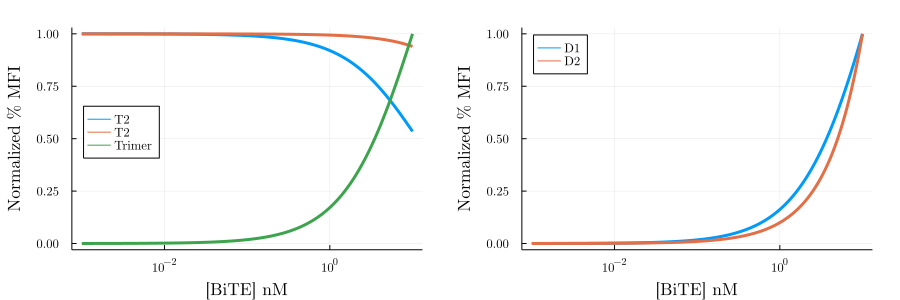

In [4]:
mfi(TMEproblem,-3,1, "TME_3")

# Optimal antibody concentration



In [5]:
# identify maximum trimer value and drug dose
function optimal(problem,dim)
    dose = 10 .^(range(-6,6,length=10000)) 
    long = simulate(problem, dose)
    value, index = findmax(long[:,dim])
    return [value, dose[index]]
end

optimal(TMEproblem,6)

2-element Vector{Float64}:
   0.09820674561524748
 140.480085044108

## Equal 
We make the binding dissociation rate and initial concentration of the two target equal (why?) in this section.

In [13]:
function sweep1(problem, name)
    resolution = 100
    trimer = zeros(resolution)
    opdrug = zeros(resolution)
    drange = 10 .^(range(-6,6,length=resolution))
    for index = 1:resolution
        problem_ = remake(problem, 
            p =vcat(problem.p[1:2], problem.p[1], drange[index]*problem.p[2]),
            u0=vcat(problem.u0[1:2], problem.u0[2], problem.u0[4:end]))
        trimer[index], opdrug[index] = optimal(problem_,6)
    end
    p1 = plot(drange,trimer, xaxis=:log, ylabel="maximum trimer conc",
        linewidth=3, label=:false, xlabel=L"kd_2/kd_1", yaxis=:log)
    p2 = plot(drange,opdrug, xaxis=:log, ylabel="optimal antibody conc",
        linewidth=3, label=:false, xlabel=L"kd_2/kd_1", yaxis=:log)
    p = plot(p1,p2,layout=(1,2))
    savefig(p, "fig/"*name*".png")
    return p
end

sweep1(TMEproblem, "TME_4")

LoadError: LoadError: UndefVarError: @L_str not defined
in expression starting at In[13]:13

GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321


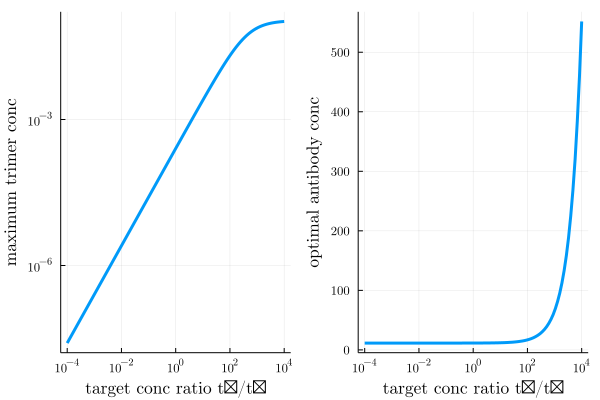

GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 8321


In [7]:
function sweep2(problem, name)
    resolution = 100
    trimer = zeros(resolution)
    opdrug = zeros(resolution)
    drange = 10 .^(range(-4,4,length=resolution))
    for index = 1:resolution
        problem_ = remake(problem, 
            p =vcat(problem.p[1:2], problem.p[1:2]),
            u0=vcat(problem.u0[1:2], drange[index]*problem.u0[2], problem.u0[4:end]))
        trimer[index], opdrug[index] = optimal(problem_,6)
    end
    p1 = plot(drange,trimer, xaxis=:log, ylabel="maximum trimer conc",
        linewidth=3, label=:false, xlabel="target conc ratio t₂/t₁", yaxis=:log)
    p2 = plot(drange,opdrug, xaxis=:log, ylabel="optimal antibody conc",
        linewidth=3, label=:false, xlabel="target conc ratio t₂/t₁")
    p = plot(p1,p2,layout=(1,2))
    savefig(p, "fig/"*name*".png")
    return p
end

sweep2(TMEproblem, "TME_5")

## Unequal

Based on dissociation and initial concentration of Betts et al model.

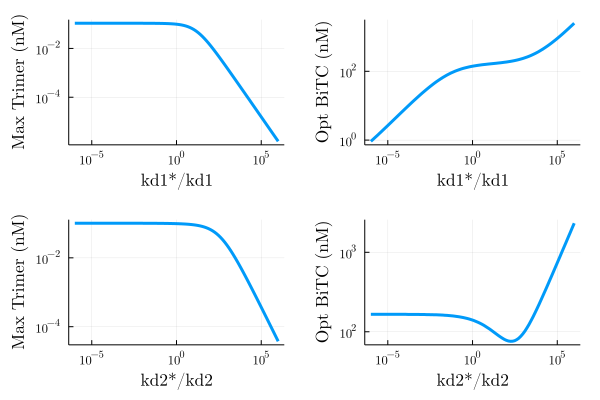

In [8]:
function s2d(problem, name)
    resolution = 100
    trimer = zeros(2,resolution)
    opdrug = zeros(2,resolution)
    drange = 10 .^(range(-6,6,length=resolution))
    for index = 1:resolution
        problem1 = remake(problem, p =vcat(problem.p[1], 
                drange[index]*problem.p[2], problem.p[3:4]))
        trimer[1,index], opdrug[1,index] = optimal(problem1,6)
        problem2 = remake(problem, p =vcat(problem.p[1:3], 
                drange[index]*problem.p[4]))
        trimer[2,index], opdrug[2,index] = optimal(problem2,6)
    end
    p1 = plot(drange,trimer[1,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="kd1*/kd1", yaxis=:log)
    p2 = plot(drange,opdrug[1,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="kd1*/kd1", yaxis=:log)
    p3 = plot(drange,trimer[2,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="kd2*/kd2", yaxis=:log)
    p4 = plot(drange,opdrug[2,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="kd2*/kd2", yaxis=:log)
    p = plot(p1,p2,p3,p4,layout=(2,2), size=(600,400), margin=3mm) 
    savefig(p, "fig/"*name*".png")
    savefig(p, "fig/"*name*".pdf")
    return p
end

s2d(TMEproblem, "TME_6")

In [9]:
function s2c(problem, name)
    resolution = 100
    trimer = zeros(2,resolution)
    opdrug = zeros(2,resolution)
    drange = 10 .^(range(-4,4,length=resolution))
    for index = 1:resolution
        problem1 = remake(problem, u0=vcat(problem.u0[1], 
                drange[index]*problem.u0[2], problem.u0[3:end]))
        problem2 = remake(problem, u0=vcat(problem.u0[1:2], 
                drange[index]*problem.u0[3], problem.u0[4:end]))
        trimer[2,index], opdrug[2,index] = optimal(problem2,6)
        trimer[1,index], opdrug[1,index] = optimal(problem1,6)
    end
    p1 = plot(drange,trimer[1,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="T1(0)*/T1(0)", yaxis=:log)
    p2 = plot(drange,opdrug[1,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="T1(0)*/T1(0)")
    p3 = plot(drange,trimer[2,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="T2(0)*/T2(0)", yaxis=:log)
    p4 = plot(drange,opdrug[2,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="T2(0)*/T2(0)")
    p = plot(p1,p2,p3,p4,layout=(2,2), size=(600,400), margin=3mm) 
    savefig(p, "fig/"*name*".png")
    savefig(p, "fig/"*name*".pdf")
    return p
end

s2c(TMEproblem, "TME_7")

LoadError: InterruptException:

In [10]:
function dismap(problem)
    resolution = 5
    trimer = zeros(resolution,resolution)
    opdrug = zeros(resolution,resolution)
    vector = range(-2,2,length=resolution)
    drange = 10 .^ vector
    for i1 = 1:resolution
        for i2 = 1:resolution
            problem_ = remake(problem, p =vcat(problem.p[1], 
                    drange[i1]*problem.p[2], problem.p[3],
                    drange[i2]*problem.p[4], problem.p[5:end]))
            trimer[i1,i2], opdrug[i1,i2] = optimal(problem_,6)
        end
    end
    p1 = plot(vector,trimer,label=:false, title="Max Trimer Conc.")
    p2 = plot(vector,opdrug,label=:false, title="Opt Drug Conc.")
    q1  = plot(p1,p2, layout=(1,2))
    savefig(q1, "fig/TME_8.png")
    p3 = heatmap(vector,vector,trimer,cgrad=:log, ylabel="kd2*/kd2", xlabel="kd₁*/kd₁")
    p4 = heatmap(vector,vector,opdrug,cgrad=:log, ylabel="kd2*/kd2", xlabel="kd₁*/kd₁")
    q2  = plot(p3,p4, layout=(1,2))
    savefig(q2, "fig/TME_9.png")
    q = plot(q1, q2, layout=(2,1), size=(900,600))
end

dismap(TMEproblem)

LoadError: InterruptException:

In [11]:
function conmap(problem)
    resolution = 5
    trimer = zeros(resolution,resolution)
    opdrug = zeros(resolution,resolution)
    vector = range(-2,2,length=resolution)
    drange = 10 .^ vector
    for i1 = 1:resolution
        for i2 = 1:resolution
            problem_ = remake(problem, u0=vcat(problem.u0[1], 
                    drange[i1]*problem.u0[2], drange[i2]*problem.u0[3],
                    problem.u0[4:end]))
            trimer[i1,i2], opdrug[i1,i2] = optimal(problem_,6)
        end
    end
    p1 = plot(vector,trimer,label=:false, title="Max Trimer Conc.")
    p2 = plot(vector,opdrug,label=:false, title="Opt Drug Conc.")
    q1  = plot(p1,p2, layout=(1,2))
    savefig(q1, "fig/TME_10.png")
    p3 = heatmap(vector,vector,trimer,cgrad=:log, ylabel="T₂*/T₂", xlabel="T₁*/T₁")
    p4 = heatmap(vector,vector,opdrug,cgrad=:log, ylabel="T₂*/T₂", xlabel="T₁*/T₁")
    q2  = plot(p3,p4, layout=(1,2))
    savefig(q2, "fig/TME_11.png")
    q = plot(q1, q2, layout=(2,1), size=(900,600))
end

conmap(TMEproblem)

LoadError: InterruptException:

# Adjourn

In [12]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2022/January/24 11:54"